In [1]:
import os
import sys
import PIL
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import glob
import csv
import pickle
# Display plots inside the notebook:
%matplotlib inline 

In [2]:
# Plotting functions
def plot_side_by_side(left_image, right_image, left_title='', right_title=''):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))    
    ax1.set_title(left_title, fontsize=30)
    ax1.imshow(left_image)    
    ax2.set_title(right_title, fontsize=30)
    ax2.imshow(right_image)
    
def plot_side_by_side_gray(left_image, right_image, left_title='', right_title=''):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))    
    ax1.set_title(left_title, fontsize=30)
    ax1.imshow(left_image, cmap='gray')    
    ax2.set_title(right_title, fontsize=30)
    ax2.imshow(right_image, cmap='gray')    
    
def show_trapezoid(img, src):
    undistorted_img = np.copy(img)
    trapezoid_img = cv2.polylines(undistorted_img, [src.astype('int32')], True, (50,205,50), thickness=2)
    plot_side_by_side(img, trapezoid_img, 'Undistorted', 'Trapezoid')
    return trapezoid_img

def bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    

In [3]:
# Read in images from folder:
def get_images_from_folder(folder_name='camera_cal'):
    cwd = os.getcwd()
    path = '{}/{}/{}'.format(cwd, folder_name, 'calibration*.jpg')
    image_paths = glob.glob(path)
    images = []
    for image_path in image_paths:
        image = mpimg.imread(image_path)
        images.append(image)
    return images

In [4]:
# Calibrate camera: 
# NOTES: board size = (# horizontal squares, # vertical squares)
def calibrate_camera(folder_in='camera_cal', folder_out='camera_cal_output', board_size=(7,10)):
    print('Calibrating', end='')
    nx = board_size[1]-1 # num vertical lines on the chessboard
    ny = board_size[0]-1 # num horizontal lines on the chessboard
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(m,n,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('{}/calibration*.jpg'.format(folder_in))

    # Count the number of images for which corners were found
    num_found = 0
    
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        print('.', end='')
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            num_found += 1
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            
            # Save images with found corners to file and display a sample image
            write_name = 'camera_cal_output/corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)
            #plt.imshow(img)
        
            
            
    # Get image size
    # img = cv2.imread(images[0])
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    calibration_data = dict()
    calibration_data["mtx"] = mtx
    calibration_data["dist"] = dist
    calibration_data["board_size"] = board_size
    pickle.dump(calibration_data, open("calibration_data.p", "wb" ) )
    #dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    if num_found >= 1:
        print('\nCalibration successful')
        print('\nChessboard corners were found on {} of {} images.\n'.format(num_found,len(images)))        
    else:
        print('\nCalibration failed.  Pease try again using different images.') 
    return mtx, dist

In [5]:
# Calibrate camera. Store calibration data in .p file
# NOTE: You can skip calibration by commenting out this line and running 
# this cell. The mtx and dist variables will be read in from the previous
# calibrations .p file.

#calibrate_camera()

# Get camera calibration data from pickle file:
calibration_data = pickle.load( open("calibration_data.p", "rb" ) )
mtx = calibration_data["mtx"]
dist = calibration_data["dist"]

In [6]:
# Undistort image:
def undistort(img, mtx, dist):
    undistorted_image = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted_image

In [51]:
def color_and_gradient_mask(img):
    # img = cv2.imread('test_images/straight_lines1.jpg')
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # print(img.shape)
    # plt.imshow(img)

    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # # NOTE: No noticeable improvement using hsv instead of hls.
    # hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # h2_channel = hls[:,:,0]
    # s2_channel = hls[:,:,1]
    # v2_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    gray = np.copy(s_channel)
    #plt.figure(figsize=(20, 10))
    #plt.imshow(gray, cmap='gray')

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 10 #20
    thresh_max = 200 #100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # Green = gradient threshold component
    # Blue  = color threshold component
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

#     # Plotting thresholded images
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
#     ax1.set_title('Stacked thresholds')
#     ax1.imshow(color_binary)

#     ax2.set_title('Combined S channel and gradient thresholds')
#     ax2.imshow(combined_binary, cmap='gray')
    return combined_binary, hls, s_channel, color_binary

In [52]:
def perspective_transform(img, src, offset=100):
    
    # Choose offset from image corners to plot detected corners
    # This should be chosen to present the result at the proper aspect ratio
    # My choice of 100 pixels is not exact, but close enough for our purpose here

    # Grab the image shape (width (pos-right), height (pos-down))
    img_size = (img.shape[1], img.shape[0])

    # For source points I'm grabbing the outer four detected corners
    # Order: top-left, top-right, bottom-right, bottom-left
    # src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                 [img_size[0]-offset, img_size[1]-offset], 
                                 [offset, img_size[1]-offset]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)   
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)   
    
    return warped

In [53]:
######################################################################################################################################
######################################################################################################################################
######################################################################################################################################

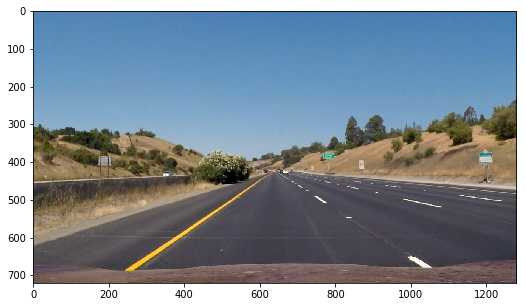

In [54]:
# Read in a test image:
original_image = bgr2rgb(cv2.imread('test_images/straight_lines1.jpg'))
plt.figure(figsize=(10,5))
plt.imshow(original_image, cmap=None)

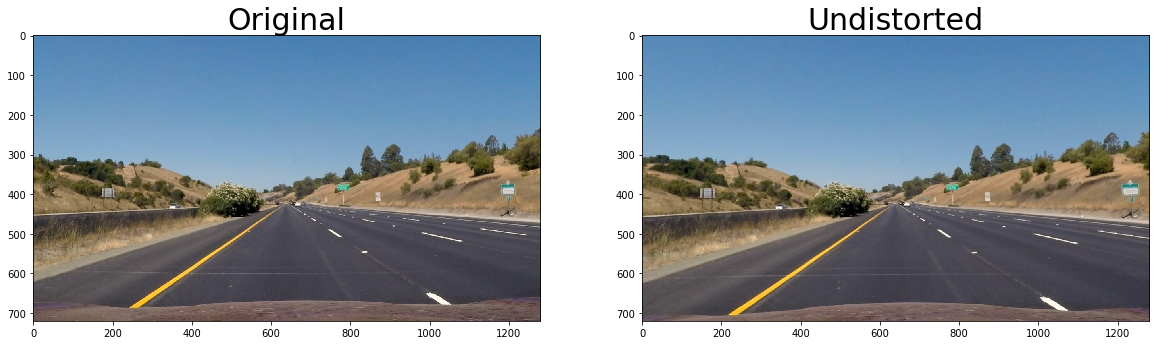

In [55]:
# Undistort image:
undistorted_image = undistort(original_image, mtx, dist)
plot_side_by_side(original_image, undistorted_image, 'Original', 'Undistorted')


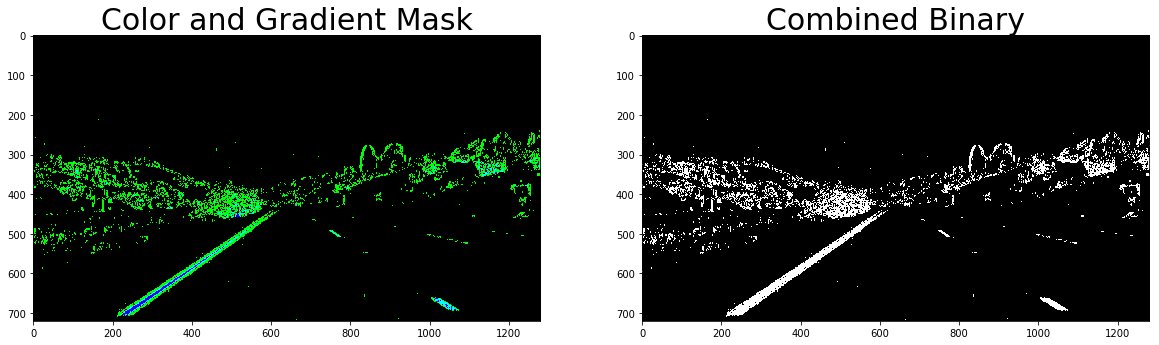

In [56]:
combined_binary, hls, s_channel, color_binary = color_and_gradient_mask(undistorted_image)
plot_side_by_side_gray(color_binary, combined_binary, 'Color and Gradient Mask', 'Combined Binary')

# plt.imshow(combined_binary, cmap='gray')
# plt.imshow(s_channel, cmap='gray')
# plt.imshow(color_binary, cmap=None)

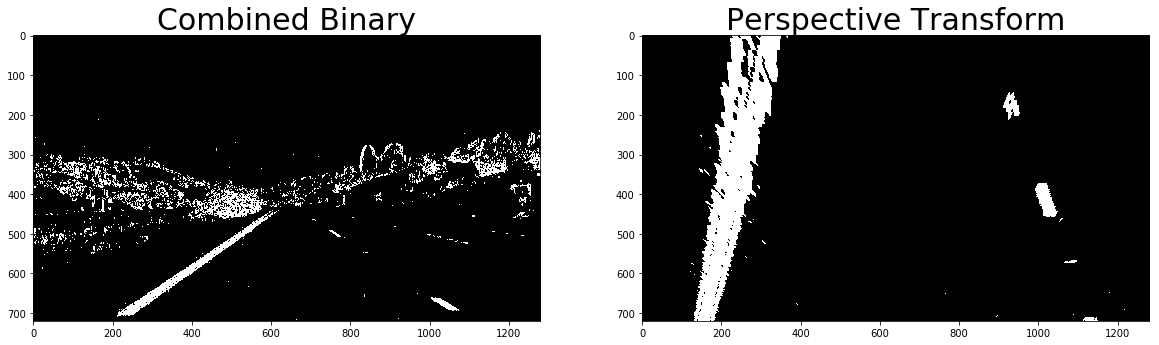

In [57]:
# Perspective transform:
src = np.float32(
    [[550, 450],
     [750, 450],
     [1150, 675],
     [150, 675]])

offset = 0 # offset for dst points

warped_binary = perspective_transform(combined_binary, src, offset)
plot_side_by_side_gray(combined_binary, warped_binary ,'Combined Binary' , 'Perspective Transform')


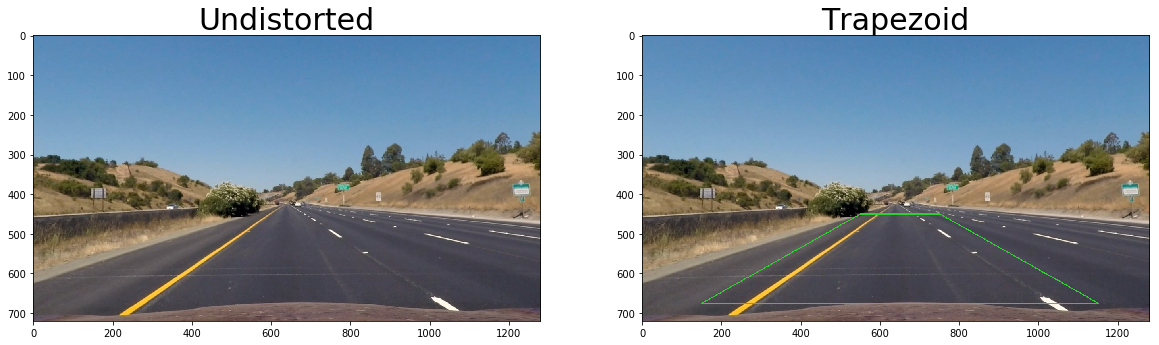

In [58]:
# Overlay the trapezoid from 'src' onto the original image:
trapezoid_img = show_trapezoid(undistorted_image, src)

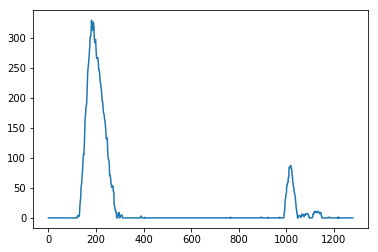

In [59]:
# Histogram of summed white pixels in each column of 
histogram = np.sum(warped_binary[warped_binary.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [60]:
######################################################################################################################################
######################################################################################################################################
######################################################################################################################################

(720, 0)

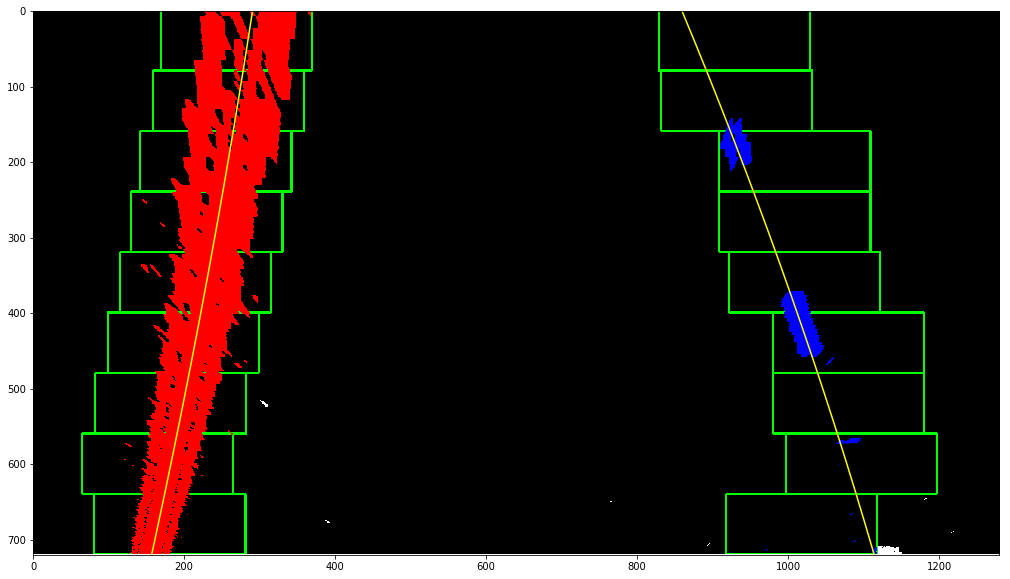

In [61]:
binary_warped = np.copy(warped_binary)

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

#Visualization
#At this point, you're done! But here is how you can visualize the result as well:

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.figure(figsize=(20,10))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [ ]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

In [ ]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [ ]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

In [ ]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m